# Rotation 1
## pharmacophore-based pose prediction

TO DO: 

- check that now supposed to be no overlap between fragment link and all structures - should i take out structures that are similar to fragments? 
- clustering
- try aligning one query mol to fragment cloud
- brute force approach
- compare to RANSAC, ICP
- quantify
- substructure matching

### Retrieve SDFs from directory (downloaded from Fragalysis)

In [4]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []
    filenames = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))
                    filenames.append(file)

    return sdf_files, filenames


### Convert SDFs to rdkit mol objects

https://www.rdkit.org/docs/GettingStartedInPython.html

In [5]:
# get mol object for each sdf file

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols


### Extract pharmacophores and their types and coordinates
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [6]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

In [7]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


Below functions similar but slightly different:
- one gets all coordinates for all mols, to collect coordinates for fragment cloud
- the second gets coordinates for a single mol which is more useful when dealing with the query molecules

In [8]:
# compute pharmacophores coordinates
# NOTE should change just to work for one molecule rather than looping through

def get_coords(mols):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []

    for mol in mols:
        # .get() will just fill with None if key doesn't exist
        pharma_coords, __ = getPharmacophoreCoords(mol)
        donor_coord = pharma_coords.get('Donor')
        acceptor_coord = pharma_coords.get('Acceptor')
        aromatic_coord = pharma_coords.get('Aromatic')

        donor_coords.append(donor_coord)
        acceptor_coords.append(acceptor_coord)
        aromatic_coords.append(aromatic_coord)

    # remove None values
    donor_coords = [x for x in donor_coords if x is not None]
    acceptor_coords = [x for x in acceptor_coords if x is not None]
    aromatic_coords = [x for x in aromatic_coords if x is not None]

    if len(donor_coords) == 0:
        donor_coords = donor_coords
    else: 
        donor_coords = np.concatenate(donor_coords)
    
    if len(acceptor_coords) == 0:
        acceptor_coords = acceptor_coords
    else:
        acceptor_coords = np.concatenate(acceptor_coords)

    if len(aromatic_coords) == 0:
        aromatic_coords = aromatic_coords
    else:
        aromatic_coords = np.concatenate(aromatic_coords)

    return donor_coords, acceptor_coords, aromatic_coords


In [9]:
def get_coords_query(mol):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []
    
    # .get() will just fill with None if key doesn't exist
    pharma_coords, __ = getPharmacophoreCoords(mol)
    donor_coords = pharma_coords.get('Donor')
    acceptor_coords = pharma_coords.get('Acceptor')
    aromatic_coords = pharma_coords.get('Aromatic')

    # remove None values
    if donor_coords is not None:
        donor_coords = [x for x in donor_coords if x is not None]
        donor_coords = np.concatenate([donor_coords])
    if acceptor_coords is not None:
        acceptor_coords = [x for x in acceptor_coords if x is not None]
        acceptor_coords = np.concatenate([acceptor_coords])
    if aromatic_coords is not None:
        aromatic_coords = [x for x in aromatic_coords if x is not None]
        aromatic_coords = np.concatenate([aromatic_coords])

    return donor_coords, acceptor_coords, aromatic_coords

### Setting up fragment point cloud

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(donor_coords, acceptor_coords, aromatic_coords):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
    labels = ['Donor', 'Acceptor', 'Aromatic']
    for coords, label in zip([donor_coords, acceptor_coords, aromatic_coords], labels):
        if len(coords) != 0:
            ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

    plt.legend()
    plt.show()

    return

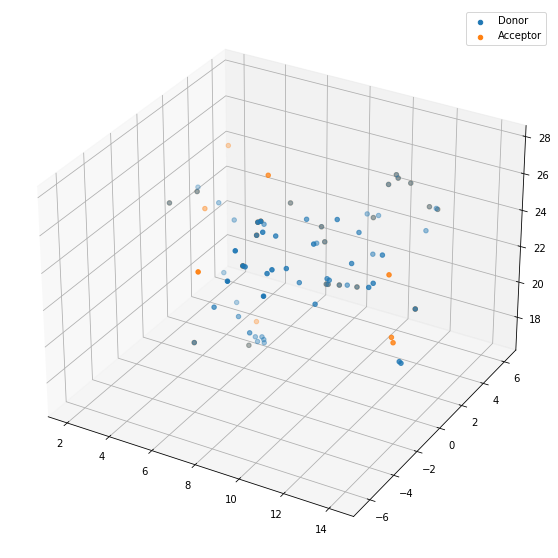

67
31


In [11]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)
plot_coords(frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords)

# NOTE ~20 fragments, number of ph4s will obvs be different
# like 67 donors, 31 acceptors
print(len(frag_donor_coords)) 
print(len(frag_acceptor_coords))


- TO DO check against pdb fragments 

### Clustering

*unfinished*
- hierarchical clustering; use agglomerative clustering (sklearn)
- aim to reduce number of points in fragment point cloud if high density in particular areas

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

def cluster(data):

    model = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=1.5)
    model.fit_predict(data)
    pred = model.fit_predict(data)
    print("number of cluster found: {}".format(len(set(model.labels_))))
    print('cluster for each point: ', model.labels_)

    return pred

### Setting up query molecules

*unfinished*

- don't need coords for conformers if testing alignment because removing coords from the query mols anyway to test alignment..
- but will still need for ground truth? 
- do i need to remove query mols that are v similar to fragments? 


- need ground truth experimental conformer which comes from sdf with coordinates, can remove coordinates and then use for alignment, need ground truth to see performance of alignment algorithm
- could generate multiple conformers and see which is the best conformer that aligns with the fragment space, adds additional layer of complexity - ultimately want this for docking (?), test a bunch of conformers and see which aligns the best (e.g. has the most ph4 matches)
- for now just use the one conformer (the experimental one) and see how the alignment works
- how to align to the fragment cloud without coordinates?  --- would have 'random' coordinates for the conformers generated, so not actually nothing there
- would expect any new query molecules given as smiles, so don't have any coordinates

In [13]:
# run same functions for query mols - get mol from sdf
query_sdfs, query_filenames = get_sdfs('Mpro_query') 
query_mols = sdf_to_mol(query_sdfs)

get conformer(s), get ph4 coords - store mols with and without coords

In [14]:
# collect query molecules with coords (ground truth, for validation) and without (for running alignment)
query_mols_yes_coords = []
query_mols_no_coords = []

for mol in query_mols:
    # gets conformer (only one in sdf file, the experimental one)
    mol.GetConformer()
    # gets coordinates of conformer
    mol.GetConformer().GetPositions()
    # run query ph4 code to get ph4 coordinates for ground truth
    query_donor_coords, query_acceptor_coords, query_aromatic_coords = get_coords_query(mol)
    query_coord_dict = {'Donor': query_donor_coords, 'Acceptor': query_acceptor_coords, 'Aromatic': query_aromatic_coords}
    # add dict of ph4 coords to a list for all the query molecules
    query_mols_yes_coords.append(query_coord_dict)
    # easy way to remove coordinates from the mol
    mol_no_cheating = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    # add query mol without coords to list of all queries with no coords
    query_mols_no_coords.append(mol_no_cheating)

# TODO multiple conformers 
#get_coords(query_mols.GetConformer().GetPositions())

# ignore for now - generating multiple conformers
# 'pruneRmsThresh' - can specify to remove similar conformers
#Generate conformers

#confIds = list(AllChem.EmbedMultipleConfs(mol_no_cheating, numConfs=10, randomSeed=21321, numThreads=2, pruneRmsThresh=1))


test plotting ph4s of first query molecule below: 

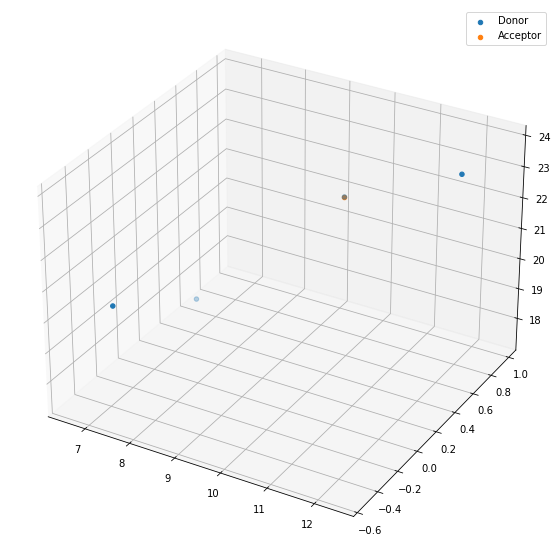

In [15]:
print(query_mols[0])
# get ph4 coords for mol
query_donor_coords, query_acceptor_coords, query_aromatic_coords = get_coords_query(query_mols[0])

# plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

labels = ['Donor', 'Acceptor', 'Aromatic']
for coords, label in zip([query_donor_coords, query_acceptor_coords, query_aromatic_coords], labels):
    if coords is not None:
        ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

plt.legend()
plt.show()

# NOTE look at how to plot from list of dicts


### Substructure matching

*unfinished* 
- remove query molecules similar to fragments?
- remove query molecules similar to each-other?

### Alignment

- below using just one query molecule (experimental conformer) and aligning to the pocket points or subsets of pocket point combinations just to test things

### RANSAC on one query molecule (query_mols[0]) against ~20 fragments: 
- registration args need changing but code runs which it didn't before
http://www.open3d.org/docs/release/python_api/open3d.pipelines.registration.registration_ransac_based_on_feature_matching.html

http://www.open3d.org/docs/0.12.0/python_api/open3d.pipelines.registration.RANSACConvergenceCriteria.html

In [ ]:
# get query and fragment coordinates for different ph4 types
query_donor_coords, query_acceptor_coords, query_aromatic_coords = get_coords_query(query_mols[0])
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)

import copy

import numpy as np
import open3d as o3d
from open3d import pipelines

#preparing data for open3d format
pocket_points = np.concatenate([frag_donor_coords, frag_acceptor_coords])
nac,ndo= [len(x) for x in [frag_donor_coords, frag_acceptor_coords]]
#This features are super simple and we need to consider things like neighbour distances
featuresIdxX = np.concatenate([np.zeros(nac)*1,np.ones(ndo)]).astype(np.int32)
featuresOneHotX = np.zeros((len(featuresIdxX), 3))
featuresOneHotX[np.arange(featuresIdxX.size),featuresIdxX] = 1

x_cloud = o3d.geometry.PointCloud()
x_cloud.points = o3d.utility.Vector3dVector(pocket_points)
x_feats = pipelines.registration.Feature()
x_feats.data = featuresOneHotX


query_points = np.concatenate([query_donor_coords, query_acceptor_coords])
nac,ndo = [len(x) for x in [query_donor_coords, query_acceptor_coords]]
featuresIdxQ = np.concatenate([np.zeros(nac)*1,np.ones(ndo)]).astype(np.int32)
featuresOneHotQ = np.zeros((len(featuresIdxQ), 3))
featuresOneHotQ[np.arange(featuresIdxQ.size),featuresIdxQ] = 1

query_cloud = o3d.geometry.PointCloud()
query_cloud.points = o3d.utility.Vector3dVector(query_points)
q_feats = pipelines.registration.Feature()
q_feats.data = featuresOneHotQ

distance_threshold = 2.


result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    query_cloud, x_cloud, q_feats, x_feats, mutual_filter=False, max_correspondence_distance=1.5)


print(result)
print(result.transformation)

transformed_query_cloud = copy.deepcopy(query_cloud)
transformed_query_cloud.transform(result.transformation)
transformed_query = np.array(transformed_query_cloud.points)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D( query_points[:,0], query_points[:,1], query_points[:,2], label="query", alpha=0.5, c=featuresIdxQ, marker="o", s=100)
ax.scatter3D(transformed_query[:,0], transformed_query[:,1], transformed_query[:,2], label="query transformed", alpha=0.5, c=featuresIdxQ, marker="x", s=100)
ax.scatter3D(pocket_points[:,0], pocket_points[:,1], pocket_points[:,2], label="pocket pharma4s", alpha=0.3, c=featuresIdxX, marker="s", s=100)
plt.legend()
plt.show()


### ICP test

try running open3d ICP example code
http://www.open3d.org/docs/0.8.0/python_api/open3d.registration.registration_icp.html 

http://www.open3d.org/docs/latest/tutorial/Basic/icp_registration.html

In [ ]:
#preparing data for open3d format
pocket_points = np.concatenate([frag_donor_coords, frag_acceptor_coords])
nac,ndo= [len(x) for x in [frag_donor_coords, frag_acceptor_coords]]
#This features are super simple and we need to consider things like neighbour distances
featuresIdxX = np.concatenate([np.zeros(nac)*1,np.ones(ndo)]).astype(np.int32)
featuresOneHotX = np.zeros((len(featuresIdxX), 3))
featuresOneHotX[np.arange(featuresIdxX.size),featuresIdxX] = 1

x_cloud = o3d.geometry.PointCloud()
x_cloud.points = o3d.utility.Vector3dVector(pocket_points)
x_feats = pipelines.registration.Feature()
x_feats.data = featuresOneHotX


query_points = np.concatenate([query_donor_coords, query_acceptor_coords])
nac,ndo = [len(x) for x in [query_donor_coords, query_acceptor_coords]]
featuresIdxQ = np.concatenate([np.zeros(nac)*1,np.ones(ndo)]).astype(np.int32)
featuresOneHotQ = np.zeros((len(featuresIdxQ), 3))
featuresOneHotQ[np.arange(featuresIdxQ.size),featuresIdxQ] = 1

query_cloud = o3d.geometry.PointCloud()
query_cloud.points = o3d.utility.Vector3dVector(query_points)
q_feats = pipelines.registration.Feature()
q_feats.data = featuresOneHotQ

distance_threshold = 2.


result = o3d.pipelines.registration.registration_icp(
    query_cloud, x_cloud, max_correspondence_distance=1.5)


print(result)
print(result.transformation)

transformed_query_cloud = copy.deepcopy(query_cloud)
transformed_query_cloud.transform(result.transformation)
transformed_query = np.array(transformed_query_cloud.points)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D( query_points[:,0], query_points[:,1], query_points[:,2], label="query", alpha=0.5, c=featuresIdxQ, marker="o", s=100)
ax.scatter3D(transformed_query[:,0], transformed_query[:,1], transformed_query[:,2], label="query transformed", alpha=0.5, c=featuresIdxQ, marker="x", s=100)
ax.scatter3D(pocket_points[:,0], pocket_points[:,1], pocket_points[:,2], label="pocket pharma4s", alpha=0.3, c=featuresIdxX, marker="s", s=100)
plt.legend()
plt.show()

### CPD test

trying to run CPD by adapting toy code example:

In [ ]:
from pycpd import RigidRegistration
pocket_points = np.concatenate([frag_donor_coords, frag_acceptor_coords])
query_points = np.concatenate([query_donor_coords, query_acceptor_coords])

# (from Ruben example) TODO: this is scale and rigid. I don't want scale

class MyRigidRegistration(RigidRegistration):

    def __init__(self, *args, **kwargs):
        super().__init__( *args, **kwargs)
        
    def register(self, callback=lambda **kwargs: None):
        self.transform_point_cloud()
        while self.iteration < self.max_iterations and self.diff > self.tolerance:
            print("self.diff", self.diff, "self.tolerance",self.tolerance, "self.max_iterations", self.iteration, self.max_iterations)
            self.iterate()
            if callable(callback):
                kwargs = {'iteration': self.iteration,
                          'error': self.q, 'X': self.X, 'Y': self.TY}
                callback(**kwargs)
                
    def update_transform(self):
        """
        Calculate a new estimate of the rigid transformation.

        """

        # target point cloud mean
        muX = np.divide(np.sum(np.dot(self.P, self.X), axis=0),
                        self.Np)
        # source point cloud mean
        muY = np.divide(
            np.sum(np.dot(np.transpose(self.P), self.Y), axis=0), self.Np)

        self.X_hat = self.X - np.tile(muX, (self.N, 1))
        # centered source point cloud
        Y_hat = self.Y - np.tile(muY, (self.M, 1))
        self.YPY = np.dot(np.transpose(self.P1), np.sum(
            np.multiply(Y_hat, Y_hat), axis=1))

        self.A = np.dot(np.transpose(self.X_hat), np.transpose(self.P))
        self.A = np.dot(self.A, Y_hat)

        # Singular value decomposition as per lemma 1 of https://arxiv.org/pdf/0905.2635.pdf.
        U, _, V = np.linalg.svd(self.A, full_matrices=True)
        C = np.ones((self.D, ))
        C[self.D-1] = np.linalg.det(np.dot(U, V))

        # Calculate the rotation matrix using Eq. 9 of https://arxiv.org/pdf/0905.2635.pdf.
        self.R = np.transpose(np.dot(np.dot(U, np.diag(C)), V))
        # Update scale and translation using Fig. 2 of https://arxiv.org/pdf/0905.2635.pdf.
        self.t = np.transpose(muX) -  np.dot(np.transpose(self.R), np.transpose(muY))


reg = MyRigidRegistration(X=pocket_points, Y=query_points, w=0.1)

def visualize(iteration, error, X, Y):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(X[:, 0],  X[:, 1], color='red', label='Target')
    ax.scatter3D(Y[:, 0],  Y[:, 1], color='blue', label='Source')
    plt.legend(loc='upper left', fontsize='x-large')
    plt.show()

def callbackPrint(*args, **kwargs):
    print("Error:", kwargs["error"])
    visualize(**kwargs)
    
reg.register(callbackPrint)


print(reg.get_registration_parameters())
transformed_query2 = reg.transform_point_cloud(Y=query_points)

# Brute force draft

https://zpl.fi/aligning-point-patterns-with-kabsch-umeyama-algorithm/
trying to use my kabsch functions to align query to fragment cloud:

- for number of points in query cloud, get that number of points in fragment cloud in each combination possible
- limit by distance, ph4 type first to reduce computation needed
- then align query to each possible combination
- get best alignment 

generating combinations of points to align against

need to have:
- all different combinations of fragment ph4 points
- each different permutation of alignment of the query points to each different point in the subset (in each combination)

limit by:
- distances between points
- type of ph4

### Brute force

https://laempy.github.io/pyoints/tutorials/icp.html icp tutorial

https://gist.github.com/bougui505/e392a371f5bab095a3673ea6f4976cc8 pytorch kabsch

https://gist.github.com/jlmelville/9b4e5d076e719a7541881e8cbf58a895 R implementation kabsch


*brute force*
- need to do kabsch but limit distance and limit combinations of points
- generate combinations of points 
- filter down to points in fragment cloud that fit restrictions
- align query molecule to filtered fragment points/'allowed' ph4s 

### Using Kabsch to align just one query molecule to one subset of pocket points

- just seeing if my Kabsch code works

In [17]:
import kabsch_functions_new as kabsch
import numpy as np

In [18]:
# concat donor and acceptor coords into one array of pocket points
pocket_points = np.concatenate([frag_donor_coords, frag_acceptor_coords])
# just checking shape of array as kabsch depends on same shaped matrices - fact check that this is a kabsch thing and not just your code
print(pocket_points.shape)

# do same for query points - just taking one for now, need to expand to run for each query/conformer
query_points = np.concatenate([query_donor_coords, query_acceptor_coords])
print(query_points.shape)

# get number of points in query cloud - will need to use this as limit for number of sets of coords in pocket subset
query_len = int(len(query_donor_coords) + len(query_acceptor_coords))
print(query_len)

# just test with subset of pocket points (will need to iterate over all combinations/permutations)
pocket_subset = pocket_points[0:query_len]

# check number of sets of coords
print(pocket_subset[:,0]) # x coords for pocket

# run kabsch functions - NOTE need to be same shape matrices input
qm_trans, qm_means = kabsch.translate_to_origin(query_points)
frm_trans, frm_means = kabsch.translate_to_origin(pocket_subset)
h = kabsch.compute_covariance_matrix(qm_trans, frm_trans)
r = kabsch.compute_optimal_rotation_matrix(h)
qm_rotated = kabsch.apply_rotation(qm_trans, r)
qm_reverted, frm_reverted = kabsch.revert_translation(qm_rotated, frm_trans, qm_means, frm_means)

rmsd_val_before = kabsch.rmsd(query_points, pocket_subset)
rmsd_val_after = kabsch.rmsd(qm_reverted, frm_reverted)

(98, 3)
(5, 3)
5
[ 4.199  6.244  1.978  3.015 10.042]


Text(0.5, 0.92, 'Test query mapped to fragments, RMSD =5.21')

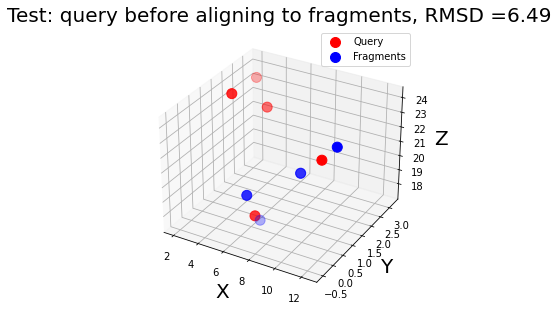

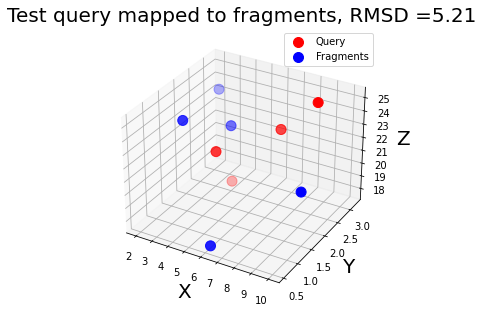

In [19]:
# plot before transformation
ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
# plot matrices for comparison 
ax.scatter3D(pocket_subset[:,0], pocket_subset[:,1], pocket_subset[:,2], label='Query', color='r', s=100)
ax.scatter3D(query_points[:,0], query_points[:,1], query_points[:,2], label='Fragments', color='b', s=100)
# set plot titles and labels
ax.legend()
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
plt.title(str('Test: query before aligning to fragments, RMSD =' + str("{:.2f}".format(rmsd_val_before))), fontsize=20)


# plot after transformation
ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
# plot matrices for comparison 
ax.scatter3D(qm_reverted[:,0], qm_reverted[:,1], qm_reverted[:,2], label='Query', color='r', s=100)
ax.scatter3D(frm_reverted[:,0], frm_reverted[:,1], frm_reverted[:,2], label='Fragments', color='b', s=100)
# set plot titles and labels
ax.legend()
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
plt.title(str('Test query mapped to fragments, RMSD =' + str("{:.2f}".format(rmsd_val_after))), fontsize=20)


Text(0.5, 0.92, 'kabsch sanity check - fragments stay in same place')

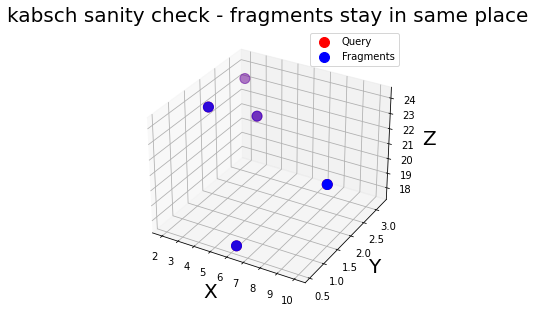

In [20]:
# kabsch sanity check - fragments should stay in same place after kabsch applied
ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d')
# plot matrices for comparison 
ax.scatter3D(pocket_subset[:,0], pocket_subset[:,1], pocket_subset[:,2], label='Query', color='r', s=100)
ax.scatter3D(frm_reverted[:,0], frm_reverted[:,1], frm_reverted[:,2], label='Fragments', color='b', s=100)
# set plot titles and labels
ax.legend()
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
plt.title('kabsch sanity check - fragments stay in same place', fontsize=20)

### Adding permutations

- mapping query molecule to subset of fragment ph4 points
- e.g. have 5 ph4 query molecule points and 5 from the fragment cloud
- as well as testing each different combination of 5 points from fragment cloud, also need to test the different pairings (i.e. correspondence) of each point from the query molecule with each in the fragment cloud subset (combination)

https://www.adamsmith.haus/python/answers/how-to-get-all-unique-combinations-of-two-lists-in-python

*should we expect different RMSD?*
- did think yes if corresponding to different points? but points transformed into best alignment anyway so maybe permutation/pairwise correspondence doesn't matter?
- either RMSD values all same or my code wrong

In [21]:
# for test pocket subset and one query molecule, get different permutations of corresponding pairs of points from both of the sets

pocket_subset = pocket_points[0:query_len]
pocket_subset_list = list(pocket_subset)
query_points_list = list(query_points)

pairwise_permutations = [list(zip(each_permutation, query_points_list)) for each_permutation in itertools.permutations(pocket_subset_list, len(query_points_list))]
print('Number of different pairings:', len(pairwise_permutations))

pockets = []
queries = []
for i in np.arange(0, len(pairwise_permutations), 1):
    for j in pairwise_permutations[i]:
        pocket = []
        query = []
        # store a new order of the points
        for k in np.arange(0,5,1):
            pocket = np.append(pairwise_permutations[0][k][0], pocket)
            query = np.append(pairwise_permutations[0][k][1], query)
        # reshape 1D arrays into matrices
        pocket = np.reshape(pocket, (5,3))
        query = np.reshape(query, (5,3))
    pockets.append(pocket)
    queries.append(query)

##print(len(pockets))
#print(pockets)
#print(len(queries))

for pocket, query in zip(pockets, queries):
    # run kabsch
    qm_trans, qm_means = kabsch.translate_to_origin(query)
    frm_trans, frm_means = kabsch.translate_to_origin(pocket)
    h = kabsch.compute_covariance_matrix(qm_trans, frm_trans)
    r = kabsch.compute_optimal_rotation_matrix(h)
    qm_rotated = kabsch.apply_rotation(qm_trans, r)
    qm_reverted, frm_reverted = kabsch.revert_translation(qm_rotated, frm_trans, qm_means, frm_means)
    # calculate RMSD
    rmsd_val = kabsch.rmsd(qm_reverted, frm_reverted)
    print(rmsd_val)

Number of different pairings: 120
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.207831961055704
5.2078319610

### Generating combinations of fragment cloud points

In [22]:
# generating combinations of fragment cloud points
import itertools

# concat donor and acceptor coords into one array of pocket points
pocket_points = np.concatenate([frag_donor_coords, frag_acceptor_coords])
# just checking shape of array as kabsch depends on same shaped matrices - fact check that this is a kabsch thing and not just your code
print(pocket_points.shape)

# do same for query points - just taking one for now, need to expand to run for each query/conformer
query_points = np.concatenate([query_donor_coords, query_acceptor_coords])
print(query_points.shape)

# get number of points in query cloud - will need to use this as limit for number of sets of coords in pocket subset
query_len = int(len(query_donor_coords) + len(query_acceptor_coords))
print(query_len)

# NOTE itertools gives object, convert to list to see len
combinations = itertools.combinations(pocket_points, 5)
#print(len(list(combinations))) # 67,910,864

# permutations 


(98, 3)
(5, 3)
5


### Running Kabsch on one query molecule vs different combinations of fragment points

- no permutations?
- just subset of combinations to test

In [26]:
pocket_subset = pocket_points[0:10]

combinations = itertools.combinations(pocket_subset, 5)
print(len(list(combinations)))

rmsd_vals = []

for combination in itertools.combinations(pocket_subset, 5):

    print(combination)
    # store combination of points as the pocket subset
    pocket_points = np.concatenate([combination])

    # rub kabsch
    qm_trans, qm_means = kabsch.translate_to_origin(query_points)
    frm_trans, frm_means = kabsch.translate_to_origin(pocket_points)
    h = kabsch.compute_covariance_matrix(qm_trans, frm_trans)
    r = kabsch.compute_optimal_rotation_matrix(h)
    qm_rotated = kabsch.apply_rotation(qm_trans, r)
    qm_reverted, frm_reverted = kabsch.revert_translation(qm_rotated, frm_trans, qm_means, frm_means)

    # calculate RMSD
    rmsd_val = kabsch.rmsd(qm_reverted, frm_reverted)
    print(rmsd_val)
    rmsd_vals.append(rmsd_val)




1
(array([ 4.199,  2.401, 22.489]), array([ 6.244,  0.543, 17.664]), array([ 1.978,  3.214, 23.166]), array([ 3.015,  1.422, 24.221]), array([10.339, -1.822, 22.355]))
5.633038357474377


### Filtering by distance
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

In [28]:
import scipy 
import numpy as np

# want to compare pairwise distances within query points to pairwise distances within fragment subset points
# if comparable, then mapping realistic
# if wildly different, using that combination of fragment points is unlikely to give good alignment

# just test with subset of pocket points (will need to iterate over all combinations/permutations)
# find pdist for pocket points
pocket_subset = pocket_points[0:query_len]
pdist_fr = scipy.spatial.distance.pdist(pocket_subset, metric='euclidean')

# find pdist for query points
pdist_q = scipy.spatial.distance.pdist(query_points, metric='euclidean')

# NOTE how to compare these sets? 
# if points not within e.g. 0.5? overall variance? use cdist?
# find difference between each pair of pdist values in both lists returned
# want minimal pairwise differences for sets of points to look similar
# in theory should be some cases where distances between sets of fragment points and query points are v similar
# question is what cutoff to use? how many combinations to get rid of? when to introduce permutations?
diffs = []
for i,j in zip(pdist_fr, pdist_q):
     diff = np.abs(i - j)
     diffs.append(diff)
diff_avg = np.mean(diffs)
print(diff_avg)


3.1983948225158607


### Distance filtering tests

- get subset of combinations of the pocket points (same length as number of coords in query)
- get pairwise distances for within pocket combination and within query points
- get differences between the 2 sets of pairwise distances (on basis that if similarly spaced points, should be similar)
- use average difference between pdists as cutoff for similarity
- compare RMSD of pocket combinations meeting and not meeting the cutoff (i.e. does filtering by distance help)

In [29]:
# see how many combinations can get rid of if cutoff set at diff values - find average diff, cut off any above mean diff 
# NOTE this is a completely arbritrary decision and will need changing, just playing around to see what will reduce combinations
# (when aligning to this one query molecule)

# get each set of combinations of point coords (just test with like 10 combinations otherwise will be here forever)
# create another bigger subset of pocket points to create combinations
pocket_subset = pocket_points[0:10]

meets_cutoff = 0
fails = 0
diff_avgs = []
cutoff_pass = []
cutoff_fail = []

for combination in itertools.combinations(pocket_subset, 5):
    # calculate pdist_fr 
    pdist_fr = scipy.spatial.distance.pdist(combination, metric='euclidean')
    # get diffs to pdist_q
    diffs = []
    for i,j in zip(pdist_fr, pdist_q):
        diff = np.abs(i - j)
        diffs.append(diff)
    # get avg diffs
    diff_avg = np.mean(diffs)
    diff_avgs.append(diff_avg)
    # get mean of means and then create a cutoff
    cutoff = np.mean(diff_avgs)
    # add to counter if average diff below cutoff
    if diff_avg <= cutoff:
        meets_cutoff += 1
        cutoff_pass.append(combination)
    else:
        fails += 1
        cutoff_fail.append(combination)

    total_combinations = meets_cutoff + fails


# see how many combinations left in list
print('Total combinations that meet cutoff:', meets_cutoff, 'out of', total_combinations, ',', str("{:.2f}".format((meets_cutoff/total_combinations)*100)) + '%')

# NOTE should check average RMSD of those meeting cutoff and those not - i.e. is lower difference b/t pdists helping alignment

Total combinations that meet cutoff: 1 out of 1 , 100.00%


In [ ]:
pass_rmsd_vals = []
fail_rmsd_vals = []

for cutoff_outcome, store_vals in zip([cutoff_pass, cutoff_fail], [pass_rmsd_vals, fail_rmsd_vals]):
    for fr_points in cutoff_outcome:
        # prep points first into right shape
        fr_points = np.concatenate([fr_points])
        # run kabsch functions - NOTE need to be same shape matrices input
        qm_trans, qm_means = kabsch.translate_to_origin(query_points)
        frm_trans, frm_means = kabsch.translate_to_origin(fr_points)
        h = kabsch.compute_covariance_matrix(qm_trans, frm_trans)
        r = kabsch.compute_optimal_rotation_matrix(h)
        qm_rotated = kabsch.apply_rotation(qm_trans, r)
        qm_reverted, frm_reverted = kabsch.revert_translation(qm_rotated, frm_trans, qm_means, frm_means)
        # calculate RMSD
        rmsd_val = kabsch.rmsd(qm_reverted, frm_reverted)
        store_vals.append(rmsd_val)


    if cutoff_outcome == cutoff_pass:
        avg_pass_rmsd = np.mean(store_vals)
        print('mean RMSD of combinations passing distance cutoff:', avg_pass_rmsd)
    elif cutoff_outcome == cutoff_fail:
        avg_fail_rmsd = np.mean(store_vals)
        print('mean RMSD of combinations failing distance cutoff:', avg_fail_rmsd)



### Distance tests pt 2

- set a cutoff that all differences in distances have to meet to pass

In [ ]:
# see how many combinations can get rid of if cutoff set at diff values - find average diff, cut off any above mean diff 
# NOTE this is a completely arbritrary decision and will need changing, just playing around to see what will reduce combinations
# (when aligning to this one query molecule)

# get each set of combinations of point coords (just test with like 10 combinations otherwise will be here forever)
# create another bigger subset of pocket points to create combinations
pocket_subset = pocket_points[0:10]

meets_cutoff = 0
fails = 0
diff_avgs = []
cutoff_pass = []
cutoff_fail = []

for combination in itertools.combinations(pocket_subset, 5):
    # calculate pdist_fr 
    pdist_fr = scipy.spatial.distance.pdist(combination, metric='euclidean')
    # get diffs to pdist_q
    diffs = []
    for i,j in zip(pdist_fr, pdist_q):
        diff = np.abs(i - j)
        diffs.append(diff)
    # look at each difference, if all meet cutoff, then add to pass list
    cutoff = 3.5
    if all(diff <= cutoff for diff in diffs) == True:
            meets_cutoff += 1
            cutoff_pass.append(combination)
    else:
        fails += 1
        cutoff_fail.append(combination)

    total_combinations = meets_cutoff + fails

# see how many combinations left in list
print('Total combinations that meet cutoff:', meets_cutoff, 'out of', total_combinations, ',', str("{:.2f}".format((meets_cutoff/total_combinations)*100)) + '%')
print('Total combinations that do not meet cutoff:', fails, 'out of', total_combinations, ',', str("{:.2f}".format((fails/total_combinations)*100)) + '%')

# NOTE should check average RMSD of those meeting cutoff and those not - i.e. is lower difference b/t pdists helping alignment

In [ ]:
pass_rmsd_vals = []
fail_rmsd_vals = []

for cutoff_outcome, store_vals in zip([cutoff_pass, cutoff_fail], [pass_rmsd_vals, fail_rmsd_vals]):
    for fr_points in cutoff_outcome:
        # prep points first into right shape
        fr_points = np.concatenate([fr_points])
        # run kabsch functions - NOTE need to be same shape matrices input
        qm_trans, qm_means = kabsch.translate_to_origin(query_points)
        frm_trans, frm_means = kabsch.translate_to_origin(fr_points)
        h = kabsch.compute_covariance_matrix(qm_trans, frm_trans)
        r = kabsch.compute_optimal_rotation_matrix(h)
        qm_rotated = kabsch.apply_rotation(qm_trans, r)
        qm_reverted, frm_reverted = kabsch.revert_translation(qm_rotated, frm_trans, qm_means, frm_means)
        # calculate RMSD
        rmsd_val = kabsch.rmsd(qm_reverted, frm_reverted)
        store_vals.append(rmsd_val)


    if cutoff_outcome == cutoff_pass:
        avg_pass_rmsd = np.mean(store_vals)
        print('mean RMSD of combinations passing distance cutoff:', avg_pass_rmsd)
    elif cutoff_outcome == cutoff_fail:
        avg_fail_rmsd = np.mean(store_vals)
        print('mean RMSD of combinations failing distance cutoff:', avg_fail_rmsd)

https://github.com/charnley/rmsd/blob/master/rmsd/calculate_rmsd.py - another implementation of Kabsch - should/could try and see if results same